# Brain Tumor Detection

We all are aware of the severeness of Cancer.It is estimated that nearly 18,000 adults die due to Brain Tumor and the survival rate tells us that if detected later then the person dies within the span of 5 years.So, it is necessary that we devise a technique for early detection of the brain tumor and in today's Modern World we have the power of AI to help us in the early diagnosis of these tumors.

# Importing the Dataset

In [2]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/brain_tumor.zip"
!unzip -qo brain_tumor.zip 
!rm brain_tumor.zip

--2020-11-03 03:03:22--  https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/brain_tumor.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.62.32
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.62.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7919366 (7.6M) [application/x-zip-compressed]
Saving to: ‘brain_tumor.zip’

brain_tumor.zip     100%[===================>]   7.55M  --.-KB/s    in 0.08s   

2020-11-03 03:03:22 (98.5 MB/s) - ‘brain_tumor.zip’ saved [7919366/7919366]



## Importing Libraries

In [3]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,MaxPool2D
from keras.layers import Conv2D, Reshape

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D


In [4]:
# Defining the dataset directory
image_dir="brain_tumor_dataset/"

#### Since the dataset is small we will augment the data and increase the dataset size

In [5]:
# Defining t=directory to store augmented images 
os.makedirs('brain_tumor_dataset/augmented-images')
os.makedirs('brain_tumor_dataset/augmented-images/yes')
os.makedirs('brain_tumor_dataset/augmented-images/no')

### Function for performing Data Augmentation

In [6]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [7]:
augmented_data_path ='brain_tumor_dataset/augmented-images/'

augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')

augment_data(file_dir=image_dir+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

## Data Preprocessing

In [8]:
# Function to crop the image
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

## After applying the cropping function

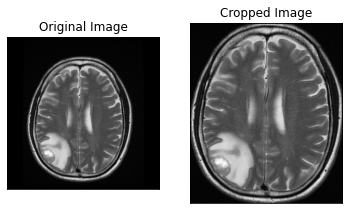

In [9]:
ex_img = cv2.imread(image_dir+'yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

## Loading the Data

In [10]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [11]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (224, 224)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 224, 224, 3)
y shape is: (2065, 1)


## Visualization of data

In [12]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

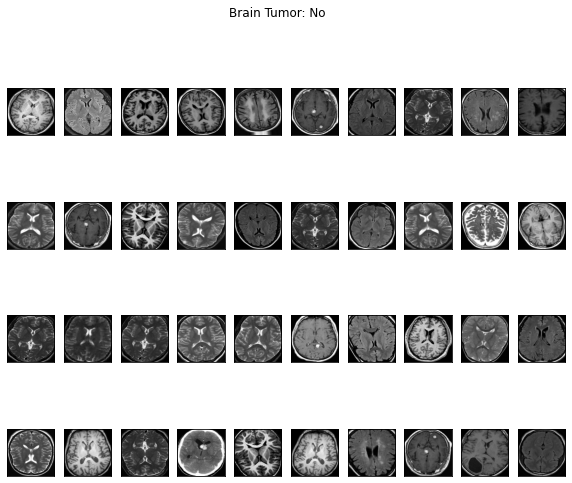

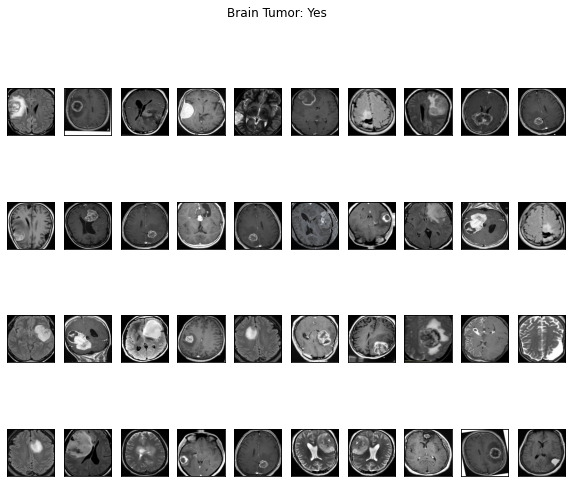

In [13]:
plot_sample_images(X, y)

## Preparing Train,Validation and Test Set

In [14]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.1)

In [16]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1858
number of validation examples = 104
number of test examples = 103


## Model Architecture

In [17]:
model=Sequential()
model.add(Conv2D(filters=32, kernel_size=7, input_shape=(224, 224, 3), activation='relu'))
model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(MaxPooling2D(pool_size=4))
model.add(MaxPooling2D(pool_size=4))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 218, 218, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 218, 218, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 54, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5409      
Total params: 10,273
Trainable params: 10,209
Non-trainable params: 64
___________________________________________________

## Model Training

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

Epoch 1/22
59/59 [==============================] - 71s 1s/step - loss: 0.6766 - accuracy: 0.6841 - val_loss: 0.6493 - val_accuracy: 0.6731
Epoch 2/22
59/59 [==============================] - 71s 1s/step - loss: 0.4431 - accuracy: 0.8009 - val_loss: 0.6111 - val_accuracy: 0.6923
Epoch 3/22
59/59 [==============================] - 71s 1s/step - loss: 0.3584 - accuracy: 0.8515 - val_loss: 0.5726 - val_accuracy: 0.7212
Epoch 4/22
59/59 [==============================] - 71s 1s/step - loss: 0.2992 - accuracy: 0.8870 - val_loss: 0.5445 - val_accuracy: 0.7500
Epoch 5/22
59/59 [==============================] - 72s 1s/step - loss: 0.3073 - accuracy: 0.8703 - val_loss: 0.4915 - val_accuracy: 0.7885
Epoch 6/22
59/59 [==============================] - 71s 1s/step - loss: 0.2555 - accuracy: 0.8891 - val_loss: 1.1344 - val_accuracy: 0.5288
Epoch 7/22
59/59 [==============================] - 72s 1s/step - loss: 0.1915 - accuracy: 0.9311 - val_loss: 0.7282 - val_accuracy: 0.6538
Epoch 8/22
59/59 [==

## Accessing the performance of Model

In [19]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 134ms/step - loss: 0.3527 - accuracy: 0.8544


[0.352741539478302, 0.8543689250946045]

## Training Plots

Text(0.5, 1.0, 'Accuracy Curves')

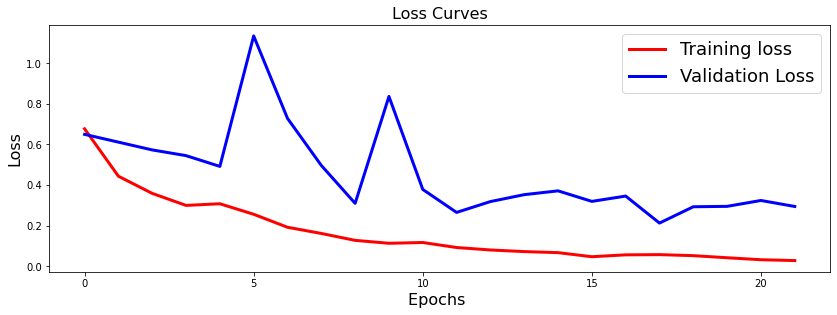

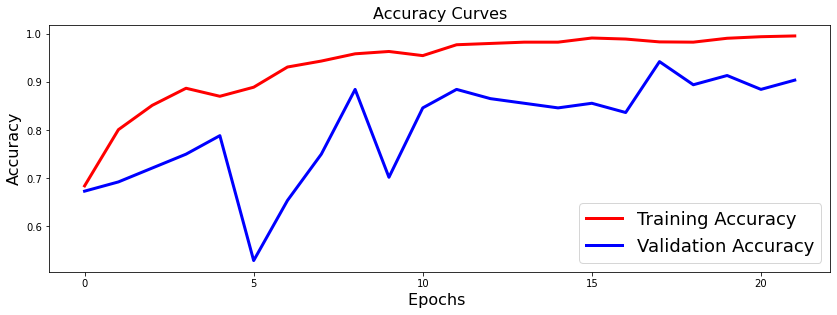

In [20]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

## Saving the Trained Model

In [21]:
model.save("BTD_model.h5")

# Compilation with DeepC

In [22]:
!deepCC BTD_model.h5

reading [keras model] from 'BTD_model.h5'
Saved 'BTD_model.onnx'
reading onnx model from file  BTD_model.onnx
Model info:
  ir_vesion :  5 
  doc       : 
WARN (ONNX): terminal (input/output) conv2d_input's shape is less than 1.
             changing it to 1.
WARN (ONNX): terminal (input/output) dense's shape is less than 1.
             changing it to 1.
WARN (GRAPH): found operator node with the same name (dense) as io node.
running DNNC graph sanity check ... passed.
Writing C++ file  BTD_model_deepC/BTD_model.cpp
INFO (ONNX): model files are ready in dir BTD_model_deepC
g++ -std=c++11 -O3 -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/packages/eigen-eigen-323c052e1731 BTD_model_deepC/BTD_model.cpp -o BTD_model_deepC/BTD_model.exe
Model executable  BTD_model_deepC/BTD_model.exe
